In [72]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from dirichletcal.calib.fulldirichlet import FullDirichletCalibrator
from sklearn.calibration import CalibratedClassifierCV
from sklearn import tree
import CalibrationM as calibm
import warnings
import Uncertainty as unc
import UncertaintyM as uncM

warnings.filterwarnings("ignore")

seed = 1
np.random.seed(seed)
calibration_method = "isotonic"
laplace = 0

# Data creation

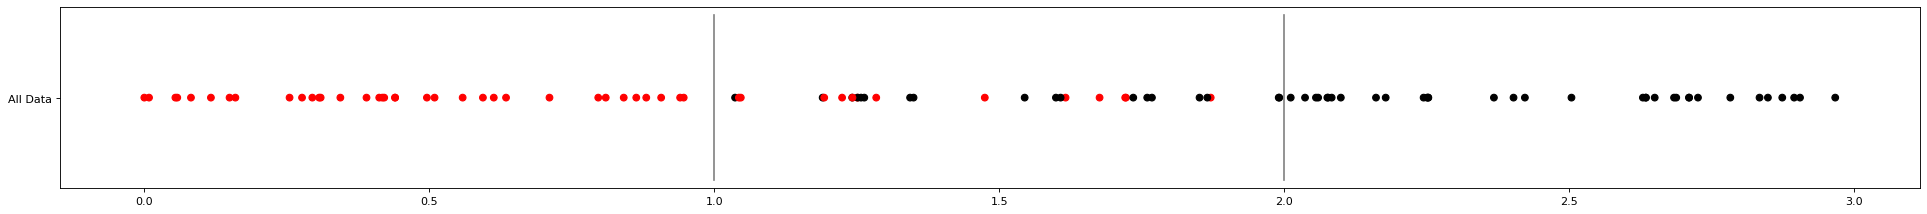

In [73]:

data_size = 100

x = np.random.uniform(low=0, high=3, size=(data_size,))
y = np.where(x<1, 0, np.where(x>2, 1, 1/2))
mid_index = np.argwhere(y==1/2)
mid_index = mid_index.reshape(-1)
rand_y = np.random.binomial(size=len(mid_index), n=1, p= 0.5)
y[mid_index] = rand_y
x = x.reshape(-1,1)

x_train, x_test_all, y_train, y_test_all = train_test_split(x, y, test_size=0.4, shuffle=True, random_state=seed)
x_test, x_calib, y_test, y_calib = train_test_split(x_test_all, y_test_all, test_size=0.5, shuffle=True, random_state=seed) 

figure(figsize=(30, 3), dpi=80)
# plt.plot(x, np.zeros_like(x), "x", color="y")
colors = ['red','black']
plt.scatter(x, np.full(len(x), "All Data"), c=y, cmap=matplotlib.colors.ListedColormap(colors))
x1, y1 = [1, 1], [1, -1]
x2, y2 = [2, 2], [1, -1]
plt.plot(x1, y1, x2, y2, c="gray")

In [74]:
# optimal prob
from math import nan

def opt_prob(threshold, x):
    p_a_0 = 1
    p_b_0 = 1/2
    p_c_0 = 0

    p_a_1 = 0
    p_b_1 = 1/2
    p_c_1 = 1

    # checking the un defined boundaries
    if threshold < 0: 
        return nan
    if threshold > 3:
        return nan

    # calculating the length of each section
    if threshold <= 1:
        a = threshold
        b = 0
        c = 0    
    if 1 < threshold <= 2:
        a = 1
        b = threshold - 1
        c = 0    
    if 2 < threshold <= 3:
        a = 1
        b = 1
        c = threshold - 2

    if x >= threshold:
        a = 1 - a
        b = 1 - b
        c = 1 - c

        threshold = 3 - threshold
    # print("side ", x)
    # print("a ", a)
    # print("b ", b)
    # print("c ", c)
    prob_1 = (a * p_a_1 + b * p_b_1 + c * p_c_1) / threshold # Probability of class one on the left side of the threshold ( here threshold is threshold)
    prob_0 = (a * p_a_0 + b * p_b_0 + c * p_c_0) / threshold # Probability of class zero on the left side of the threshold

    return prob_0, prob_1

In [75]:
opt_prob(2, 1.8) # It does not mater if x moves in a section, the prob will only change if x changes section. Prob will always change if the threshold changes.

(0.75, 0.25)

# Model: Decision stump ensembel

In [76]:
model = RandomForestClassifier(max_depth=1, n_estimators=2, random_state=seed)
model.fit(x_train, y_train)
predictions_x_test = model.predict(x_test)
prob_x_test = model.predict_proba(x_test)
prob_x_calib = model.predict_proba(x_calib)

# Member calibration

Tree [0] threshold 1.2514901757240295
Normal          ECE 0.11296296296296299  [0.03703704 1.        ]
calibration iso ECE 0.17500000000000002  [0.21428571 1.        ]
optimal prob [0.21404221294150183, 0.8995237115710741]
------------------------------------
Tree [1] threshold 1.6921833753585815
Normal          ECE 0.15000000000000002  [0.         0.90322581]
calibration iso ECE 0.23888888888888893  [0.22222222 0.63636364]
optimal prob [0.11768340409566848, 0.7954762511445]
------------------------------------


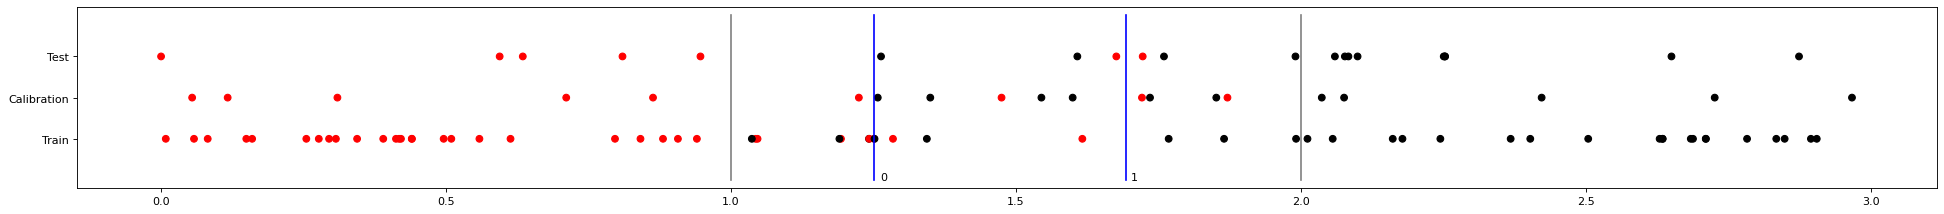

In [77]:
thresholds = []
figure(figsize=(30, 3), dpi=80)

for est_index, estimator in enumerate(model.estimators_):
    # tree.plot_tree(estimator)
    tree_threshold = estimator.tree_.threshold[0]
    tree_prob_x_test = estimator.predict_proba(x_test)

    # print(tree_prob_x_test)
    
    print(f"Tree [{est_index}] threshold {tree_threshold}")
    print(f"Normal          ECE {calibm.confidance_ECE(tree_prob_x_test, y_test)} ", np.unique(tree_prob_x_test[:,0]))

    # Full Dirichlet
    if calibration_method == "isotonic":
        model_calib = CalibratedClassifierCV(estimator, cv="prefit", method=calibration_method) # cv=30
        model_calib.fit(x_calib , y_calib)
        tree_prob_x_test_calib = model_calib.predict_proba(x_test)

        print(f"calibration iso ECE {calibm.confidance_ECE(tree_prob_x_test_calib, y_test)} ", np.unique(tree_prob_x_test_calib[:,0]))

    if calibration_method == "Dir":
        skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
        reg = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
        calibrator = FullDirichletCalibrator(reg_lambda=reg, reg_mu=None)
        dir_calib = GridSearchCV(calibrator, param_grid={'reg_lambda':  reg, 'reg_mu': [None]}, cv=skf, scoring='neg_log_loss')
        dir_calib.fit(prob_x_calib , y_calib)
        tree_prob_x_test_calib = dir_calib.predict_proba(tree_prob_x_test)
        
        print(f"calibration dir ECE {calibm.confidance_ECE(tree_prob_x_test_calib, y_test)} ", np.unique(tree_prob_x_test_calib[:,0]))

    # optimal prob
    thresholds.append(tree_threshold)
    o_p_pos_r, _ = opt_prob(tree_threshold, tree_threshold + 0.1)
    o_p_pos_l, _ = opt_prob(tree_threshold, tree_threshold - 0.1)
    print(f"optimal prob [{o_p_pos_r}, {o_p_pos_l}]")
    print("------------------------------------")

    plt.plot([tree_threshold,tree_threshold], [3,-1], c="blue")
    plt.annotate(est_index, (tree_threshold+0.01, -1))

plt.scatter(x_train, np.full(len(x_train), "Train"), c=y_train, cmap=matplotlib.colors.ListedColormap(colors))
# for i, txt in enumerate(np.ones(len(x_train))): # attempt to label the training data of each tree in the RF (plot works but cannot access the training subsets)
#     plt.annotate(int(txt), (x_train[i], "Train"))

plt.scatter(x_calib, np.full(len(x_calib), "Calibration"), c=y_calib, cmap=matplotlib.colors.ListedColormap(colors))
plt.scatter(x_test, np.full(len(x_test), "Test"), c=y_test, cmap=matplotlib.colors.ListedColormap(colors))
x1, y1 = [1, 1], [3, -1]
x2, y2 = [2, 2], [3, -1]
plt.plot(x1, y1, x2, y2, c="gray")

# Ens Calibration

In [78]:
print(f"Normal          ECE {calibm.confidance_ECE(prob_x_test, y_test)} {np.unique(prob_x_test[:,0])}")

if calibration_method == "isotonic":
    model_calib = CalibratedClassifierCV(model, cv="prefit", method=calibration_method) # cv=30
    model_calib.fit(x_calib , y_calib)
    prob_x_test_calib = model_calib.predict_proba(x_test)

    print(f"calibration iso ECE {calibm.confidance_ECE(prob_x_test_calib, y_test)} ", np.unique(prob_x_test_calib[:,0]))

# Full Dirichlet
if calibration_method == "Dir":
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=0)
    reg = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
    calibrator = FullDirichletCalibrator(reg_lambda=reg, reg_mu=None)
    dir_calib = GridSearchCV(calibrator, param_grid={'reg_lambda':  reg, 'reg_mu': [None]}, cv=skf, scoring='neg_log_loss')
    dir_calib.fit(prob_x_calib , y_calib)
    prob_x_test_calib = dir_calib.predict_proba(prob_x_test)

    print(f"calibration dir ECE {calibm.confidance_ECE(prob_x_test_calib, y_test)} ", np.unique(prob_x_test_calib[:,0]))


Normal          ECE 0.09599761051373959 [0.01851852 0.47013142 0.9516129 ]
calibration iso ECE 0.17500000000000002  [0.21428571 1.        ]


# ECE calculation

In [79]:
normal_cw_ece = calibm.classwise_ECE(prob_x_test, y_test)
normal_conf_ece = calibm.confidance_ECE(prob_x_test, y_test)

print(normal_cw_ece)
print(normal_conf_ece)

[0.0911589008363202, 0.09115890083632024]
0.09599761051373959


# Uncertainty

In [80]:
# unc Q id
tu, eu, au = unc.model_uncertainty(model, x_test, x_train, y_train, laplace_smoothing=laplace)
tumc, eumc, aumc, porb_matrix = unc.calib_ens_member_uncertainty(model, x_test, y_test, x_train, y_train, x_calib, y_calib, calibration_method, seed)
tuc = unc.calib_ens_total_uncertainty(prob_x_test_calib)

# true tree prob for each x_test and true aleatoric uncertianty

In [81]:
prob_x_test_true = []

for x in x_test:
    for threshold in thresholds:
        p_0, p_1 = opt_prob(threshold, x)
        prob_x_test_true.append([p_0, p_1])

prob_x_test_true = np.array(prob_x_test_true).reshape(len(x_test), len(thresholds), 2) # D1 data D2 ens member D3 class prob

# uncertainty for true prob
tuo, euo, auo = uncM.uncertainty_ent_bays(prob_x_test_true, np.full(len(thresholds), 1/len(thresholds)))

# true ens prob for each x_test

In [140]:
data_size_p_ens = 10

x_p_ens = np.random.uniform(low=0, high=3, size=(data_size_p_ens,))
y_p_ens = np.where(x_p_ens<1, 0, np.where(x_p_ens>2, 1, 1/2))
mid_index_p_ens = np.argwhere(y_p_ens==1/2)
mid_index_p_ens = mid_index_p_ens.reshape(-1)
rand_y_p_ens = np.random.binomial(size=len(mid_index_p_ens), n=1, p= 0.5)
y_p_ens[mid_index_p_ens] = rand_y_p_ens
x_p_ens = x_p_ens.reshape(-1,1)

x_p_ens_pred = model.predict(x_p_ens)
u, count = np.unique(x_p_ens_pred, return_counts=True)

print("true", y_p_ens)
print("pred", x_p_ens_pred)
print("------------------------------------")
print(u, count)

ens_pred_0 = np.where(x_p_ens_pred==0)
# print("ens_pred_0", ens_pred_0)
y_p_ens_0 = y_p_ens[ens_pred_0]
# print(y_p_ens_0)
ens_pred_0_corr = np.where(y_p_ens_0 == x_p_ens_pred[ens_pred_0])
# print(ens_pred_0_corr)

ens_pred_1 = np.where(x_p_ens_pred==1)
y_p_ens_1 = y_p_ens[ens_pred_1]
ens_pred_1_corr = np.where(y_p_ens_1 == x_p_ens_pred[ens_pred_1])


print(len(ens_pred_0_corr[0]))
print(count[0])
print("------------------------------------")
print(len(ens_pred_1_corr[0]))
print(count[1])


p_0_ens = len(ens_pred_0_corr[0]) / count[0]
p_1_ens = len(ens_pred_1_corr[0]) / count[1]
print(p_0_ens)
print(p_1_ens)

true [0. 1. 1. 0. 1. 1. 0. 0. 1. 0.]
pred [1. 1. 1. 0. 1. 1. 0. 0. 0. 1.]
------------------------------------
[0. 1.] [4 6]
3
4
------------------------------------
4
6
0.75
0.6666666666666666


In [ ]:
import pandas as pd

opt_p = prob_x_test_true.mean(axis=1)

data = np.concatenate((x_test, prob_x_test[:,0].reshape(-1,1), prob_x_test_calib[:,0].reshape(-1,1), opt_p[:,0].reshape(-1,1), au.reshape(-1,1), aumc.reshape(-1,1), auo.reshape(-1,1)), axis=1)
data_df = pd.DataFrame(data, columns=["x", "n_prob", "c_prob", "o_prob", "a_unc", "a_unc_c", "a_unc_o"])
data_df

,x,n_prob,c_prob,o_prob,a_unc,a_unc_c,a_unc_o
0,2.083200,0.018519,0.214286,0.165863,0.038275,0.757096,0.635902
1,0.594304,0.951613,1.000000,0.847500,0.381867,0.485556,0.600694
2,1.990324,0.018519,0.214286,0.165863,0.038275,0.757096,0.635902
3,0.000343,0.951613,1.000000,0.847500,0.381867,0.485556,0.600694
4,2.252436,0.018519,0.214286,0.165863,0.038275,0.757096,0.635902
5,0.946547,0.951613,1.000000,0.847500,0.381867,0.485556,0.600694
6,2.059503,0.018519,0.214286,0.165863,0.038275,0.757096,0.635902
7,0.634884,0.951613,1.000000,0.847500,0.381867,0.485556,0.600694
8,2.252827,0.018519,0.214286,0.165863,0.038275,0.757096,0.635902
9,2.076968,0.018519,0.214286,0.165863,0.038275,0.757096,0.635902


# order of x_test based on uncertainties

In [ ]:
comp, comp_p = uncM.order_comparison([au], [aumc])
print(f"order_comparison uncalibrated and calibrated {comp}")

comp, comp_p = uncM.order_comparison([aumc], [auo])
print(f"order_comparison calibrated and optimal {comp}")


order_comparison uncalibrated and calibrated -0.08108108108108109
order_comparison calibrated and optimal 1.0


In [ ]:
print("Area under: ")
print("uncalibrated AU ", uncM.unc_auroc(predictions_x_test, y_test, au))
print("calibrated   AU ", uncM.unc_auroc(predictions_x_test, y_test, aumc))
print("optimal      AU ", uncM.unc_auroc(predictions_x_test, y_test, auo))


Area under: 
uncalibrated AU  0.625
calibrated   AU  0.763888888888889
optimal      AU  0.763888888888889


# true uncertainty plot value

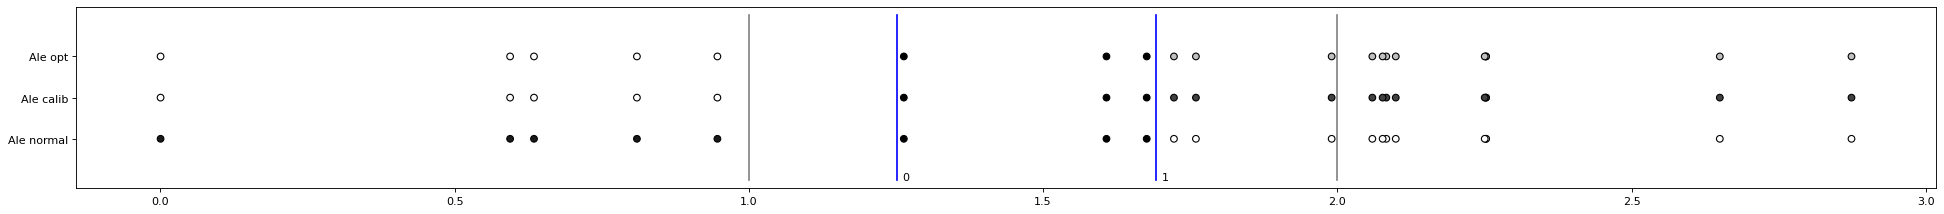

In [ ]:
figure(figsize=(30, 3), dpi=80)

colors = ['red','black']
plt.scatter(x_test, np.full(len(x_test), "Ale normal"), c=au, cmap="gist_yarg", edgecolors='black')
plt.scatter(x_test, np.full(len(x_test), "Ale calib"), c=aumc, cmap="gist_yarg", edgecolors='black')
plt.scatter(x_test, np.full(len(x_test), "Ale opt"), c=auo, cmap="gist_yarg", edgecolors='black')

for est_index, threshold in enumerate(thresholds):
    plt.plot([threshold,threshold], [3,-1], c="blue")
    plt.annotate(est_index, (threshold+0.01, -1))

x1, y1 = [1, 1], [3, -1]
x2, y2 = [2, 2], [3, -1]
plt.plot(x1, y1, x2, y2, c="gray")
